In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances, silhouette_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform, cityblock
import sklearn
from sklearn.metrics.pairwise import euclidean_distances
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import itertools
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

In [3]:
def preprocess_data_for_dbscan(data):
    # Drop irrelevant columns (if needed)
    data = data.drop(['ID'], axis=1)

    # Handle missing values
    data = handle_missing_values(data)

    # Encode categorical variables
    data = encode_categorical(data)

    # Standardize numerical features
    data = standardize_numerical(data)

    return data

def handle_missing_values(data):
    # Use SimpleImputer to fill missing values with 0 (for numerical features)
    numerical_cols = data.select_dtypes(include=['float64']).columns
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    data[numerical_cols] = imputer.fit_transform(data[numerical_cols])

    return data

def encode_categorical(data):
    # Use LabelEncoder to convert categorical variables into numerical format
    label_encoder = LabelEncoder()
    categorical_cols = data.select_dtypes(include=['object']).columns
    data[categorical_cols] = data[categorical_cols].apply(lambda col: label_encoder.fit_transform(col.astype(str)))

    return data

def standardize_numerical(data):
    # Use StandardScaler to standardize numerical features
    numerical_cols = data.select_dtypes(include=['float64']).columns
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    return data


def cluster_analysis(feature_matrix, eps_dbscan=0.2, min_samples_dbscan=10, show_dendrogram=True):
    # DBSCAN
    dbscan = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan, metric='euclidean')
    clusters_dbscan = dbscan.fit_predict(feature_matrix)
    num_clusters_dbscan = len(set(clusters_dbscan))

    # Convert to Distance Matrix for Hierarchical Clustering
    cluster_centers = [feature_matrix[clusters_dbscan == cluster_id].mean(axis=0) for cluster_id in set(clusters_dbscan)]
    distance_matrix = pairwise_distances(cluster_centers, cluster_centers, metric='euclidean')

    # Suppress the ClusterWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        # Hierarchical Clustering
        linkage_matrix = linkage(distance_matrix, method='average', metric='euclidean')
    final_labels = fcluster(linkage_matrix, num_clusters_dbscan, criterion='maxclust')

    dbscan_cluster_sizes = {dbscan_cluster_label: np.sum(clusters_dbscan == dbscan_cluster_label) for dbscan_cluster_label in set(clusters_dbscan)}

    # Create a mapping from DBSCAN clusters to hierarchical clusters
    dbscan_to_hierarchical_map = {}
    for dbscan_cluster_label, hierarchical_cluster_label in zip(np.unique(clusters_dbscan), final_labels):
        if dbscan_cluster_label not in dbscan_to_hierarchical_map:
            dbscan_to_hierarchical_map[dbscan_cluster_label] = hierarchical_cluster_label
        else:
            assert dbscan_to_hierarchical_map[dbscan_cluster_label] == hierarchical_cluster_label
    
    return linkage_matrix, dbscan_to_hierarchical_map, dbscan_cluster_sizes, final_labels


def softmax_regression(linkage_matrix, dbscan_to_hierarchical_map, size, final_labels):
    # Function to perform softmax regression
    
    # Convert linkage_matrix to probabilities using softmax
    softmax_probs = np.exp(-linkage_matrix[:, 2]) / np.sum(np.exp(-linkage_matrix[:, 2]))

    # Assign softmax probabilities to hierarchical clusters based on DBSCAN clusters
    hierarchical_probs = np.zeros_like(final_labels, dtype=np.float64)
    for dbscan_cluster_label, hierarchical_cluster_label in dbscan_to_hierarchical_map.items():
        hierarchical_probs[final_labels == hierarchical_cluster_label] = softmax_probs[dbscan_cluster_label]

    # Normalize probabilities to sum to 1 for each sample
    hierarchical_probs /= np.sum(hierarchical_probs)

    # Display more details about the output
    details = []
    for sample_idx, (sample_size, sample_label) in enumerate(zip(size, final_labels)):
        detail = {
            'Sample Index': sample_idx,
            'DBSCAN Cluster': sample_label,
            'DBSCAN Cluster Size': sample_size,
            'Hierarchical Cluster': dbscan_to_hierarchical_map[sample_label],
            'Hierarchical Probability': hierarchical_probs[sample_idx],
            'Softmax Probability': softmax_probs[sample_label]
        }
        details.append(detail)

    return {'softmax_probs': softmax_probs, 'details': details}


def cut_dendrogram_and_map(linkage_matrix, criterion, criterion_type='maxclust'):
    """
    Cut the dendrogram based on a criterion, display the dendrogram, and return a mapping of all old clusters to new clusters.

    Parameters:
    - linkage_matrix: The precomputed linkage matrix obtained from hierarchical clustering.
    - criterion: The number of clusters or height threshold depending on the criterion_type.
    - criterion_type: 'maxclust' for specifying the number of clusters or 'distance' for specifying a height threshold.

    Returns:
    - final_labels: Cluster labels assigned to each data point after cutting the dendrogram.
    - cluster_mapping: Dictionary mapping all old clusters to new clusters after the cut.
    """
    # Cut the dendrogram based on the specified criterion
    final_labels = fcluster(linkage_matrix, criterion, criterion=criterion_type)
    
    # Create a mapping from all old clusters to new clusters
    cluster_mapping = {old_cluster: new_cluster for old_cluster, new_cluster in zip(range(1, len(final_labels) + 1), final_labels)}

    # Display the dendrogram with cluster labels
    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix, labels=final_labels)
    plt.title("Hierarchical Clustering Dendrogram with Cluster Labels")
    plt.xlabel("Data Points")
    plt.ylabel("Distance")
    plt.show()

    return final_labels, cluster_mapping
        


In [4]:
# train_data = pd.read_csv("/kaggle/input/customer/Train.csv")

# train_data_clean = train_data[['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
#        'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']]
# Y = train_data[['Segmentation']]
# train_data_clean = preprocess_data_for_dbscan(train_data_clean)
# train_data_clean.head()
# # Y.head()

# X_train, X_valid, y_train, y_valid = train_test_split(train_data_clean, Y, test_size=0.2, random_state=42)

# # best working values 

# e_value = 2.1
# ms = 27
# linkage_matrix, dbscan_to_hierarchical_map, size, final_labels = cluster_analysis(X_train, eps_dbscan=e_value, min_samples_dbscan=ms)

# result = softmax_regression(linkage_matrix, dbscan_to_hierarchical_map, size, final_labels)
# softmax_probs = result['softmax_probs']
# details = result['details']

# print("Softmax Probabilities:")
# print(softmax_probs)
# print("\nDetails:")
# for detail in details:
#     print(detail)
    
# linkage_matrix

# cut_dendrogram_and_map(linkage_matrix, 4)

In [5]:
df = pd.read_csv("Household_power_consumption.csv")


In [6]:
def convert_data_types(df):
    # Convert 'Date' and 'Time' columns to string
    # df['Date'] = df['Date'].astype(str)
    df['datetime'] = df['datetime'].astype(str)

    # Replace non-numeric values with 0 and then convert to double
    numeric_columns = df.columns.difference(['datetime'])  # Exclude 'Date' and 'Time' columns
    df[numeric_columns] = df[numeric_columns].replace('?', 0).astype(float)

    # Replace NaN values with 0
    df.fillna(0, inplace=True)

    return df

In [7]:
df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [8]:
train_data_converted = convert_data_types(df)[["Global_active_power", "Global_reactive_power", "Voltage", "Global_intensity", 
                                                       "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]]

In [9]:
train_data_converted.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0



Details:
{'Sample Index': 0, 'DBSCAN Cluster': 2671, 'DBSCAN Cluster Size': 0, 'Hierarchical Cluster': 267, 'Hierarchical Probability': 0.0, 'Softmax Probability': 4.723792856227321e-13}
{'Sample Index': 1, 'DBSCAN Cluster': 2673, 'DBSCAN Cluster Size': 1, 'Hierarchical Cluster': 1448, 'Hierarchical Probability': 0.022608039178226912, 'Softmax Probability': 4.668132832131018e-13}
{'Sample Index': 2, 'DBSCAN Cluster': 2672, 'DBSCAN Cluster Size': 2, 'Hierarchical Cluster': 1425, 'Hierarchical Probability': 0.021192763680637536, 'Softmax Probability': 4.70533363480835e-13}
{'Sample Index': 3, 'DBSCAN Cluster': 2702, 'DBSCAN Cluster Size': 3, 'Hierarchical Cluster': 2361, 'Hierarchical Probability': 0.02113986952085021, 'Softmax Probability': 2.2388299051612037e-13}
{'Sample Index': 4, 'DBSCAN Cluster': 2382, 'DBSCAN Cluster Size': 4, 'Hierarchical Cluster': 1331, 'Hierarchical Probability': 0.019361540503050778, 'Softmax Probability': 1.2403940414414856e-10}
{'Sample Index': 5, 'DBSCAN 

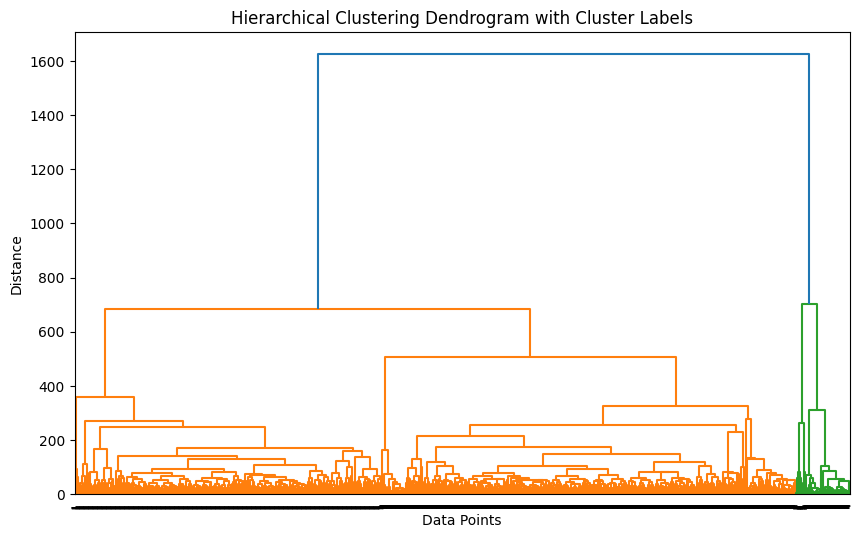

(array([2, 2, 2, ..., 2, 4, 2], dtype=int32),
 {1: 2,
  2: 2,
  3: 2,
  4: 2,
  5: 2,
  6: 2,
  7: 2,
  8: 2,
  9: 2,
  10: 2,
  11: 2,
  12: 2,
  13: 2,
  14: 2,
  15: 2,
  16: 2,
  17: 2,
  18: 2,
  19: 2,
  20: 2,
  21: 2,
  22: 2,
  23: 2,
  24: 2,
  25: 2,
  26: 2,
  27: 2,
  28: 2,
  29: 2,
  30: 2,
  31: 2,
  32: 2,
  33: 2,
  34: 2,
  35: 2,
  36: 1,
  37: 1,
  38: 1,
  39: 1,
  40: 1,
  41: 1,
  42: 1,
  43: 1,
  44: 1,
  45: 1,
  46: 1,
  47: 1,
  48: 1,
  49: 1,
  50: 1,
  51: 1,
  52: 1,
  53: 1,
  54: 1,
  55: 1,
  56: 1,
  57: 1,
  58: 1,
  59: 2,
  60: 2,
  61: 2,
  62: 2,
  63: 2,
  64: 2,
  65: 2,
  66: 1,
  67: 1,
  68: 1,
  69: 1,
  70: 1,
  71: 1,
  72: 1,
  73: 1,
  74: 1,
  75: 1,
  76: 1,
  77: 1,
  78: 1,
  79: 1,
  80: 1,
  81: 2,
  82: 2,
  83: 2,
  84: 2,
  85: 2,
  86: 2,
  87: 2,
  88: 4,
  89: 2,
  90: 2,
  91: 2,
  92: 2,
  93: 2,
  94: 2,
  95: 2,
  96: 2,
  97: 2,
  98: 2,
  99: 2,
  100: 2,
  101: 2,
  102: 2,
  103: 2,
  104: 2,
  105: 2,
  106: 2,
  

In [10]:
linkage_matrix, dbscan_to_hierarchical_map, size, final_labels = cluster_analysis(train_data_converted)#, eps_dbscan=e_value, min_samples_dbscan=ms)

result = softmax_regression(linkage_matrix, dbscan_to_hierarchical_map, size, final_labels)
softmax_probs = result['softmax_probs']
details = result['details']

# print("Softmax Probabilities:")
# print(softmax_probs)
print("\nDetails:")
for detail in details:
    print(detail)
    
linkage_matrix

cut_dendrogram_and_map(linkage_matrix, 4)